<a href="https://colab.research.google.com/github/mahbodnr/Mask-Detection/blob/main/Semantic_Pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [2]:
!pip install -q git+https://github.com/Singular-Brain/DeepBioLCNet

     |████████████████████████████████| 120 kB 5.1 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 280 kB 47.5 MB/s 
     |████████████████████████████████| 28.5 MB 48 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!wget https://data.deepai.org/mnist.zip
!mkdir -p ../data/MNIST/TorchvisionDatasetWrapper/raw
!unzip mnist.zip -d ../data/MNIST/TorchvisionDatasetWrapper/raw/

--2021-10-22 10:03:55--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  11.2MB/s    in 1.0s    

2021-10-22 10:03:56 (11.2 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz  


In [4]:
!git clone https://github.com/Singular-Brain/DeepBioLCNet/

Cloning into 'DeepBioLCNet'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 311 (delta 110), reused 221 (delta 51), pack-reused 0
Receiving objects: 100% (311/311), 31.43 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [5]:
from bindsnet.network.nodes import Nodes
import os
import torch
import random
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import collections
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch.nn.functional as fn

from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network, load
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes, IFNodes
from bindsnet.network.topology import LocalConnection, Connection, LocalConnectionOrig, MaxPool2dLocalConnection
from bindsnet.network.monitors import Monitor, AbstractMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET, WeightDependentPostPre, Hebbian
from bindsnet.learning.reward import DynamicDopamineInjection, DopaminergicRPE
from bindsnet.analysis.plotting import plot_locally_connected_weights,plot_locally_connected_weights_meh,plot_spikes,plot_locally_connected_weights_meh2,plot_convergence_and_histogram,plot_locally_connected_weights_meh3
from bindsnet.analysis.visualization import plot_weights_movie, plot_spike_trains_for_example,summary, plot_voltage
from bindsnet.utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights

## Sets up Gpu use and manual seed


In [6]:
if torch.cuda.is_available():
    device =  torch.device("cuda")
    gpu = True
else:
    device =  torch.device("cpu")
    gpu = False

def manual_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


SEED = 2045 # The Singularity is Near!
manual_seed(SEED)
WANDB = True

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)

Running on Device =  cpu


In [7]:
if WANDB:
    !pip install -q wandb
    !wandb login
    import wandb

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 139 kB 67.8 MB/s 
     |████████████████████████████████| 97 kB 5.8 MB/s 
     |████████████████████████████████| 180 kB 69.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Custom Monitors

## Plot Eligibility trace

In [14]:
class PlotET(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        i,
        j,
        source,
        target,
        connection,
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()
        self.i = i
        self.j = j
        self.source = source
        self.target = target
        self.connection = connection

        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if hasattr(self.connection.update_rule, 'p_plus'):
            self.recording['spikes_i'].append(self.source.s.ravel()[self.i].item())
            self.recording['spikes_j'].append(self.target.s.ravel()[self.j].item())
            self.recording['p_plus'].append(self.connection.update_rule.p_plus[self.i].item())
            self.recording['p_minus'].append(self.connection.update_rule.p_minus[self.j].item())
            self.recording['eligibility'].append(self.connection.update_rule.eligibility[self.i,self.j].item())
            self.recording['eligibility_trace'].append(self.connection.update_rule.eligibility_trace[self.i,self.j].item())
            self.recording['w'].append(self.connection.w[self.i,self.j].item())

    def plot(self):

        fig, axs  = plt.subplots(7)
        fig.set_size_inches(10, 20)
        for i, (name, p) in enumerate(self.recording.items()):
            axs[i].plot(p[-250:])
            axs[i].set_title(name)
    
        fig.show()

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = {
        'spikes_i': [],
        'spikes_j': [],
        'p_plus':[],
        'p_minus':[],
        'eligibility':[],
        'eligibility_trace':[],
        'w': [],
        }


## Kernel 

In [15]:
class AbstractKernel(ABC):
    def __init__(self, kernel_size):
        """
        Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
        Instantiates a ``Filter Kernel`` object.
        :param window_size : The size of the kernel (int)
        """
        self.window_size = kernel_size

    def __call__(self):
        pass

class DoGKernel(AbstractKernel):
    def __init__(self, kernel_size: Union[int, Tuple[int, int]], sigma1 : float, sigma2 : float):
        """
        Generates DoG filter kernels.
        :param kernel_size: Horizontal and vertical size of DOG kernels.(If pass int, we consider it as a square filter) 
        :param sigma1 : The sigma parameter for the first Gaussian function.
        :param sigma2 : The sigma parameter for the second Gaussian function.
        """
        super(DoGKernel, self).__init__(kernel_size)
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        
    def __call__(self):
        k = self.window_size//2
        x, y = np.mgrid[-k:k+1:1, -k:k+1:1]
        a = 1.0 / (2 * math.pi)
        prod = x*x + y*y
        f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
        f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
        dog = a * (f1-f2)
        dog_mean = np.mean(dog)
        dog = dog - dog_mean
        dog_max = np.max(dog)
        dog = dog / dog_max
        dog_tensor = torch.from_numpy(dog)
        # returns a 2d tensor corresponding to the requested DoG filter
        return dog_tensor.float()

class Filter():
    """
    Applies a filter transform. Each filter contains a sequence of :attr:`FilterKernel` objects.
    The result of each filter kernel will be passed through a given threshold (if not :attr:`None`).
    Args:
        filter_kernels (sequence of FilterKernels): The sequence of filter kernels.
        padding (int, optional): The size of the padding for the convolution of filter kernels. Default: 0
        thresholds (sequence of floats, optional): The threshold for each filter kernel. Default: None
        use_abs (boolean, optional): To compute the absolute value of the outputs or not. Default: False
    .. note::
        The size of the compund filter kernel tensor (stack of individual filter kernels) will be equal to the 
        greatest window size among kernels. All other smaller kernels will be zero-padded with an appropriate 
        amount.
    """
    # filter_kernels must be a list of filter kernels
    # thresholds must be a list of thresholds for each kernel
    def __init__(self, filter_kernels, padding=0, thresholds=None, use_abs=False):
        tensor_list = []
        self.max_window_size = 0
        for kernel in filter_kernels:
            if isinstance(kernel, torch.Tensor):
                tensor_list.append(kernel)
                self.max_window_size = max(self.max_window_size, kernel.size(-1))
            else:
                tensor_list.append(kernel().unsqueeze(0))
                self.max_window_size = max(self.max_window_size, kernel.window_size)
        for i in range(len(tensor_list)):
            p = (self.max_window_size - filter_kernels[i].window_size)//2
            tensor_list[i] = fn.pad(tensor_list[i], (p,p,p,p))

        self.kernels = torch.stack(tensor_list)
        self.number_of_kernels = len(filter_kernels)
        self.padding = padding
        if isinstance(thresholds, list):
            self.thresholds = thresholds.clone().detach()
            self.thresholds.unsqueeze_(0).unsqueeze_(2).unsqueeze_(3)
        else:
            self.thresholds = thresholds
        self.use_abs = use_abs

    # returns a 4d tensor containing the flitered versions of the input image
    # input is a 4d tensor. dim: (minibatch=1, filter_kernels, height, width)
    def __call__(self, input):

        # if input.dim() == 3:
        #     input2 = torch.unsqueeze(input, 0)
        input.unsqueeze_(0)
        output = fn.conv2d(input, self.kernels, padding = self.padding).float()
        if not(self.thresholds is None):
            output = torch.where(output < self.thresholds, torch.tensor(0.0, device=output.device), output)
        if self.use_abs:
            torch.abs_(output)
        return output.squeeze(0)

# Design network

In [16]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1
def convergence(c):
    if c.norm is None:
        return 1-torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2
    else:
        mean_norm_factor = c.norm / c.w.shape[-1]
        return  1-(torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2)


class LCNet(Network):
    def __init__(
        self,
        dt: float,
        time: int,
        channels: list,
        filters: list,
        strides: list,
        input_channels: int,
        nu_LC: Union[float, Tuple[float, float]],
        NodesType,
        crop_size:int,
        inh_type: bool,
        nu_inh: float,
        inh_factor: float,
        norm_factor: float,
        update_rule,
        update_rule_inh,
        wmin: float,
        wmax: float ,
        soft_bound: bool,
        theta_plus: float,
        tc_theta_decay: float,
        tc_trace:int,
        trace_additive,
        wandb_active:bool,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Constructor for class ``BioLCNet``.

        :param n_inpt: Number of input neurons. Matches the 1D size of the input data.
        :param n_neurons: Number of excitatory, inhibitory neurons.
        :param exc: Strength of synapse weights from excitatory to inhibitory layer.
        :param inh: Strength of synapse weights from inhibitory to excitatory layer.
        :param dt: Simulation time step.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param wmin: Minimum allowed weight on input to excitatory synapses.
        :param wmax: Maximum allowed weight on input to excitatory synapses.
        :param norm: Input to excitatory layer connection weights normalization
            constant.
        :param theta_plus: On-spike increment of ``(adaptive)LIFNodes`` membrane
            threshold potential.
        :param tc_theta_decay: Time constant of ``(adaptive)LIFNodes`` threshold
            potential decay.
        :param inpt_shape: The dimensionality of the input layer.
        """
        manual_seed(SEED)
        super().__init__(dt=dt, reward_fn = None, online=True)
        

        self.dt = dt
        self.time = time
        self.input_channels = input_channels
        self.channels = channels
        self.filters = filters
        self.strides = strides
        self.update_rule = update_rule
        self.nu_LC = nu_LC
        self.NodesType = NodesType
        self.crop_size = crop_size
        self.inh_type = inh_type
        self.inh_factor = inh_factor
        self.clamp_intensity = kwargs.get('clamp_intensity',None)
        self.soft_bound = soft_bound
        self.norm_factor =norm_factor
        self.convergences = {}
        self.wmin = wmin 
        self.wmax = wmax
        self.wandb_active = wandb_active
        self.epochs_trained = 0

        ### nodes
        inp = Input(shape= [input_channels,crop_size,crop_size], traces=True, tc_trace=tc_trace,traces_additive = trace_additive)
        self.add_layer(inp, name="layer0")

        last_layer_size = crop_size
        last_layer = inp
        last_layer_channels = 1

        assert type(self.channels) == list
        network_hparams = [self.channels, self.filters, self.strides,
                           self.norm_factor, self.wmin, self.wmax,
                           self.soft_bound, self.update_rule, self.nu_LC,
                           self.NodesType, self.inh_type, self.inh_factor]
        network_hparams_list = []
        for hparam in network_hparams:
            if type(hparam) == list:
                network_hparams_list.append(hparam)
            else:
                network_hparams_list.append([hparam] * len(channels))
        assert all([len(hparam)==len(channels) for hparam in network_hparams_list])
        for i, (
                    n_channels, filter_size, stride, norm_LC,
                    wmin, wmax, soft_bound, update_rule, nu_LC,
                    NodesType, inh_type, inh_factor
                ) in enumerate(zip(*network_hparams_list)
                ):
            new_layer_size = compute_size(last_layer_size, filter_size, stride)
            new_layer = NodesType(
                shape= [n_channels, new_layer_size, new_layer_size],
                traces=True, tc_trace=tc_trace,traces_additive = trace_additive,
                tc_theta_decay = tc_theta_decay, theta_plus = theta_plus
                )
            self.add_layer(new_layer, name=f"layer{i+1}")
            ### connections 
            LC_connection = LocalConnection(
                last_layer, new_layer,
                filter_size, stride,
                last_layer_channels, n_channels,
                input_shape = [last_layer_size]*2,
                nu = nu_LC, update_rule= update_rule,
                wmin = wmin, wmax= wmax, soft_bound = soft_bound,
                norm = norm_LC)
            self.add_connection(LC_connection, f"layer{i}", f"layer{i+1}")
            ###
            last_layer_size = new_layer_size
            last_layer = new_layer
            last_layer_channels = n_channels
            ### Inhibitory connection
            if inh_type == 'recurrent':
                w_inh_LC = torch.zeros(n_channels,new_layer_size,new_layer_size,n_channels,new_layer_size,new_layer_size)
                for c in range(n_channels):
                    for w1 in range(new_layer_size):
                        for w2 in range(new_layer_size):
                            w_inh_LC[c,w1,w2,:,w1,w2] = - inh_factor
                            w_inh_LC[c,w1,w2,c,w1,w2] = 0
            
                w_inh_LC = w_inh_LC.reshape(new_layer.n,new_layer.n)
                                                            
                LC_recurrent_inhibition = Connection(
                    source=new_layer,
                    target=new_layer,
                    w=w_inh_LC,
                    nu= nu_inh,
                )
                self.add_connection(LC_recurrent_inhibition, f"layer{i+1}", f"layer{i+1}")

            elif inh_type == 'lateral':
                inh_neurons_layer = LIFNodes(
                    shape= [n_channels],
                    traces=True, tc_trace=tc_trace,traces_additive = trace_additive,
                    tc_theta_decay = tc_theta_decay, theta_plus = theta_plus
                    ).to(device)
                self.add_layer(inh_neurons_layer, name=f"layer{i+1}_inh_neurons")

                w_inh_LC = torch.zeros(n_channels, n_channels,new_layer_size,new_layer_size)
                w_inh_LC_rev = torch.zeros(n_channels, new_layer_size, new_layer_size, n_channels)

                for c in range(n_channels):
                    for w1 in range(new_layer_size):
                        for w2 in range(new_layer_size): 
                            w_inh_LC[c,c,w1,w2] = -inh_factor
                            w_inh_LC_rev[c,w1,w2,c] = 1/(new_layer_size**2)

                w_inh_LC = w_inh_LC.reshape(n_channels, new_layer.n)
                w_inh_LC_rev = w_inh_LC_rev.reshape(new_layer.n, n_channels)

                LC_lateral_inhibition = Connection(
                    source=inh_neurons_layer,
                    target=new_layer,
                    w=w_inh_LC,
                    nu= nu_inh,
                ).to(device)

                LC_lateral_inhibition_rev = Connection(
                    source=new_layer,
                    target=inh_neurons_layer,
                    w=w_inh_LC_rev,
                    nu= nu_inh,
                ).to(device)

                self.add_connection(LC_lateral_inhibition, f"layer{i+1}_inh_neuron", f"layer{i+1}")
                self.add_connection(LC_lateral_inhibition_rev, f"layer{i+1}",f"layer{i+1}_inh_neuron")

        self.to(device)


    def fit(
        self,
        dataloader,
        n_train = 2000,
        verbose = True,
    ):
        manual_seed(SEED)
        self.verbose = verbose
        if self.wandb_active:
            wandb.watch(self)
            
        # add Monitors
        #Plot_et = PlotET(i = 0, j = 0, source = self.layers["main"], target = self.layers["output"], connection = self.connections[("main","output")])
        #self.add_monitor(Plot_et, name="Plot_et")

        self.spikes = {}
        for layer in set(self.layers):
            self.spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=None)
            self.add_monitor(self.spikes[layer], name="%s_spikes" % layer)

        pbar = tqdm(total=n_train)
        self.reset_state_variables()

        for (i, datum) in enumerate(dataloader):
            if i>=n_train:
                break

            image = datum["encoded_image"]
            # Run the network on the input.
            if gpu:
                inputs = {"layer0": image.cuda().view(self.time, 1, self.input_channels, self.crop_size, self.crop_size)}
            else:
                inputs = {"layer0": image.view(self.time, 1, self.input_channels, self.crop_size, self.crop_size)}
            ### Spike clamping (baseline activity)
            clamp = {}
            if self.clamp_intensity is not None:
                encoder = PoissonEncoder(time = self.time, dt = self.dt)
                clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

            self.run(inputs=inputs, 
                    time=self.time, 
                    one_step=True,
                    clamp = clamp
                     )

            # Get voltage recording.

            if verbose:
                print(f"\r ",
                    f"input_mean_fire_freq: {torch.mean(image.float())*1000:.1f}",
                    '- Spikes:', {name: monitor.get('s').sum().item() for name, monitor in self.spikes.items()},
                    '- Layers Mean:', list(map(lambda x: {x[0]: round(x[1].w.mean().item(),3)}, self.connections.items())),
                    '- convergences:', {name: round(convergence(c).item() , 5) for name, c in self.connections.items() if c.wmin!=-np.inf and c.wmax!=np.inf },
                    '- std:', {name: round(c.w.std().item() , 5) for name, c in self.connections.items() if c.wmin!=-np.inf and c.wmax!=np.inf },
                    end = ''
                    )
                   
            if self.wandb_active:
                wandb.log({
                        **{' to '.join(name) + ' convergence': convergence(c).item() for name, c in self.connections.items() if name[0]!=name[1]},
                        **{' to '.join(name) + ' std': c.w.std().item() for name, c in self.connections.items() if name[0]!=name[1]},
                        **{name + ' spikes': monitor.get('s').sum().item() for name, monitor in self.spikes.items()},
                        **{' to '.join(name) + " gradients": wandb.Histogram(c.w.cpu()) for name, c in self.connections.items() if name[0]!=name[1]},
                    },
                    step = self.epochs_trained)
            #Plot_et.plot()    
            self.reset_state_variables()  # Reset state variables.
            
            # pbar.set_description_str("")
            pbar.update()
            self.epochs_trained +=1


    def predict(
        self,
        val_loader,
        n_pred,
    ):
        manual_seed(SEED)

        monitors = []
        for layer in self.layers:
            if layer == 'layer0':
                continue
            monitor = Monitor(self.layers[layer], ["s", "v"], time=time)
            monitors.append(monitor)
            self.add_monitor(monitor, name=f"{layer} monitor")
        self.train(False)
        S= []
        V= []
        y= []
        pbar = tqdm(total=n_pred)
        for (i, datum) in enumerate(val_loader):
            if i > n_pred:
                break

            image = datum["encoded_image"]
            if self.label is None : 
              label = datum["label"]
            else :
              label = self.label

            # Run the network on the input.
            if gpu:
                inputs = {"layer0": image.cuda().view(self.time, 1, self.input_channels, self.crop_size, self.crop_size)}
            else:
                inputs = {"layer0": image.view(self.time, 1, self.input_channels, self.crop_size, self.crop_size)}

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    one_step = True,
                    true_label = label.int().item(),
                    dopaminergic_layers= self.dopaminergic_layers,
                     )

            S.append(list(map(lambda x: x.get('s'), monitors)))
            V.append(list(map(lambda x: x.get('v'), monitors)))
            y.append(label)

            self.reset_state_variables()  # Reset state variables.
            pbar.update()

        self.train(True)
        return S, V ,y

# Load Dataset

In [17]:
class ClassSelector(torch.utils.data.sampler.Sampler):
    """Select target classes from the dataset"""
    def __init__(self, target_classes, data_source, mask = None):
        if mask is not None:
            self.mask = mask
        else:
            self.mask = torch.tensor([1 if data_source[i]['label'] in target_classes else 0 for i in range(len(data_source))])
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

In [18]:
kernels = [DoGKernel(7,1,2),
			DoGKernel(7,2,1),]
filter = Filter(kernels, padding = 3, thresholds = 50/255)
# Load MNIST data.

def load_datasets(network_hparams, data_hparams, mask=None, test_mask=None):
    manual_seed(SEED)
    dataset = MNIST(
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        transform=transforms.Compose(
            [
                transforms.CenterCrop(data_hparams['crop_size']),
                transforms.ToTensor(),
                # filter,
                transforms.Lambda(lambda x: (
                    x.round() if data_hparams['round_input'] else x
                ) * data_hparams['intensity']),
            ]
        ),
    )

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = dataset,
                                                    mask = mask,
                                                    ) if target_classes else None
                                            )

    # Load test dataset
    test_dataset = MNIST(   
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (
                    x.round() if data_hparams['round_input'] else x
                ) * data_hparams['intensity']),
                transforms.CenterCrop(data_hparams['crop_size'])
                # filter,
                ]
        ),
    )

    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = test_dataset,
                                                    mask = mask_test,
                                                    ) if target_classes else None
                                            )
    

    return dataloader, val_loader

# Set up hyper-parameters

In [19]:
# Dataset Hyperparameters
target_classes = None #(0,1)
if target_classes:
    npz_file = np.load(f'bindsnet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    # npz_file = np.load('bindsnet/mask_0_1.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
    
else:
    mask = None
    mask_test = None
    n_classes = 10

data_hparams = { 
    'intensity': 256,
    'crop_size': 22,
    'round_input': False,
}

In [20]:
network_hparams = {
    # net structure
    'channels': [20,40],
    'filters': [3,2],
    'strides': [1,2],
    'input_channels': 1,
    # time & Phase
    'time': 50,
    'dt' : 1,
    # Nodes
    'NodesType': [LIFNodes, LIFNodes],
    'theta_plus': 0.2,
    'tc_theta_decay': 200,
    'tc_trace':50,
    'trace_additive' : False,
    # Learning
    'update_rule': PostPre,
    'update_rule_inh' : None,
    'nu_LC': [1e-2,1],
    'soft_bound': True,
    'wmin': [0,0],
    'wmax': [1,1],
    # Inhibition
    'nu_inh': 0.0,
    'inh_LC': True,
    'inh_type': 'recurrent',
    'inh_factor': [20,20],
    # Normalization
    'norm_factor': [0.5*3**2, .5*2**2],
    # clamp
    'clamp_intensity': None,
}



In [21]:
# network_hparams = {
#     # net structure
#     'channels': [20],
#     'filters': [11],
#     'strides': [3],
#     'input_channels': 1,
#     # time & Phase
#     'time': 50,
#     'dt' : 1,
#     # Nodes
#     'NodesType': AdaptiveLIFNodes,
#     'theta_plus': 0.05,
#     'tc_theta_decay': 1e6,
#     'tc_trace':20,
#     'trace_additive' : False,
#     # Learning
#     'update_rule': PostPre,
#     'update_rule_inh' : None,
#     'nu_LC': (1e-4, 1e-2),
#     'soft_bound': False,
#     'wmin': [0],
#     'wmax': [1],
#     # Inhibition
#     'nu_inh': 0.0,
#     'inh_LC': True,
#     'inh_type': 'recurrent',
#     'inh_factor': 10,
#     # Normalization
#     'norm_factor': [0.5*11*11],
#     'norm_factor_inh': None,
#     'norm_factor_inh_LC': None,
#     # clamp
#     'clamp_intensity': None,
# }


In [22]:
dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test)

Using downloaded and verified file: ../../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz
Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw

Using downloaded and verified file: ../../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz
Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw

Using downloaded and verified file: ../../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw

Using downloaded and verified file: ../../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz
Extracting ../../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/TorchvisionDatasetWrapper/raw



# Training

In [10]:
x = wandb.init(project='SemanticPooling', entity='singularbrain', config=network_hparams)

In [23]:
manual_seed(SEED)
if WANDB:
    wandb_run = wandb.init(project='SemanticPooling', entity='singularbrain', config=network_hparams)
net = LCNet(**network_hparams, **data_hparams, wandb_active = WANDB)
net

(LCNet(
   (layer0): Input()
   (layer1): LIFNodes()
   (layer0_to_layer1): LocalConnection(
     (source): Input()
     (target): LIFNodes()
   )
   (layer1_to_layer1): Connection(
     (source): LIFNodes()
     (target): LIFNodes()
   )
   (layer2): LIFNodes()
   (layer1_to_layer2): LocalConnection(
     (source): LIFNodes()
     (target): LIFNodes()
   )
   (layer2_to_layer2): Connection(
     (source): LIFNodes()
     (target): LIFNodes()
   )
 ), <wandb.sdk.wandb_run.Run at 0x7fcb89cff2d0>)

In [25]:
wandb_run

In [26]:
net.fit(n_train = 2_000, dataloader = dataloader)

  0%|          | 0/2000 [00:00<?, ?it/s]

  input_mean_fire_freq: 48.8 - Spikes: {'layer1': 523, 'layer2': 58, 'layer0': 1181} - Layers Mean: [{('layer0', 'layer1'): 0.5}, {('layer1', 'layer1'): -0.047}, {('layer1', 'layer2'): 0.5}, {('layer2', 'layer2'): -0.195}] - convergences: {('layer0', 'layer1'): 0.30983, ('layer1', 'layer2'): 0.27528} - std: {('layer0', 'layer1'): 0.27831, ('layer1', 'layer2'): 0.26234}

KeyboardInterrupt: ignored

**Save Model:**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# net.save(f'/content/drive/My Drive/LCNet/{wandb_run.name}.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparameter search

## Set up configuration

In [ ]:
assert WANDB

sweep_config = {
    'method': 'grid',
    
    'metric' : {
        'name': 'layer0 to layer1 convergence',
        'goal': 'maximize'   
    },

    'parameters' : {
        'channels': {
            'values': [10,50]
        },
        'filter_size': {
            'values': [3,5,7,9,11,13]
        },
        'stride': {
            'values': [1, 2, 3]
        },
        
        'soft_bound': {
            'values': [True, False]
        },

    }
}

sweep_id = wandb.sweep(sweep_config, project="SemanticPooling", entity='singularbrain')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: o2ufvw2v
Sweep URL: https://wandb.ai/singularbrain/semanticpooling/sweeps/o2ufvw2v


## OR set a sweep_id

In [ ]:
sweep_id = '6wci6m94'

In [ ]:
!wandb agent singularbrain/semanticpooling/$sweep_id

wandb: Starting wandb agent 🕵️
2021-10-19 20:15:45,004 - wandb.wandb_agent - INFO - Running runs: []
2021-10-19 20:15:45,785 - wandb.wandb_agent - INFO - Agent received command: run
2021-10-19 20:15:45,785 - wandb.wandb_agent - INFO - Agent starting run with config:
	channels: 10
	filter_size: 7
	soft_bound: False
	stride: 1
2021-10-19 20:15:45,787 - wandb.wandb_agent - INFO - About to run command: /usr/bin/env python  --channels=10 --filter_size=7 --soft_bound=False --stride=1
/usr/bin/python3: can't find '__main__' module in ''
2021-10-19 20:15:50,799 - wandb.wandb_agent - INFO - Running runs: ['13pxt7jz']
2021-10-19 20:15:50,800 - wandb.wandb_agent - INFO - Cleaning up finished run: 13pxt7jz
2021-10-19 20:15:51,012 - wandb.wandb_agent - INFO - Agent received command: run
2021-10-19 20:15:51,013 - wandb.wandb_agent - INFO - Agent starting run with config:
	channels: 10
	filter_size: 7
	soft_bound: False
	stride: 2
2021-10-19 20:15:51,015 - wandb.wandb_agent - INFO - About to run comm

In [ ]:
def train(config=None):
    with wandb.init(project="SemanticPooling", entity='singularbrain', config=config, resume= True,):
        config = wandb.config
        net = LCNet(
            **{
            # net structure
            'channels': [config.channels],
            'filters': [config.filter_size],
            'strides': [config.stride],
            'input_channels': 1,
            # time & Phase
            'time': 50,
            'dt' : 1,
            # Nodes
            'NodesType': [AdaptiveLIFNodes],
            'theta_plus': 0.1,
            'tc_theta_decay': 1000,
            'tc_trace':50,
            'trace_additive' : False,
            # Learning
            'update_rule': PostPre,
            'update_rule_inh' : None,
            'nu_LC': [(1e-4, 1e-2)],
            'soft_bound': [config.soft_bound],
            'wmin': [0],
            'wmax': [1],
            # Inhibition
            'nu_inh': 0.0,
            'inh_LC': True,
            'inh_type': 'recurrent',
            'inh_factor': [20],
            # Normalization
            'norm_factor': [0.5* config.filter_size**2],
            # clamp
            'clamp_intensity': None,
            }, 
            **data_hparams,
            wandb_active = True,
        )
        net.fit(n_train = 1000, dataloader = dataloader)

wandb.agent(sweep_id, train)

404 response executing GraphQL.
{"errors":[{"message":"could not find project mahbod/uncategorized during createAgent","path":["createAgent"]}],"data":{"createAgent":null}}
wandb: ERROR Error while calling W&B API: could not find project mahbod/uncategorized during createAgent (<Response [404]>)


CommError: ignored

# **Following lines are NOT edited yet!**

### Visualization 

In [ ]:
net = LCNet(**network_hparams, **data_hparams, wandb_active = WANDB)

net.layers['layer1'].shape

[20, 4, 4]

In [ ]:
net.connections[('layer0', 'layer1')].w.shape

torch.Size([1, 320, 121])

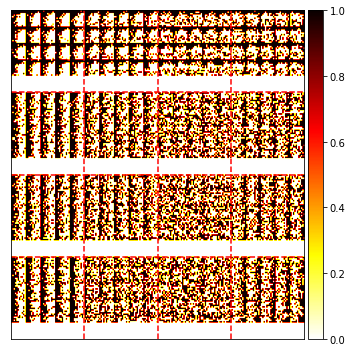

In [ ]:
plot_locally_connected_weights_meh(net.connections[('layer0', 'layer1')].w,20,1,0,20,11,4)

In [ ]:
dataloader_iterator = iter(dataloader)
for i in range(10):
    datum = next(dataloader_iterator)
    plt.imshow(datum['encoded_image'].squeeze().sum(0))
    plt.show()
    net.one_step(datum)
    spikes = net.spikes["main1"].get("s").sum(0).squeeze().view(4*5,4*5)
    print(torch.max(spikes))
    plot_locally_connected_weights_meh2(net.connections[('input', 'main1')].w,spikes,25,1,0,22,13,4)
    plt.show()

# SVM

In [ ]:
network_hparams.update({'LC_weights_path':'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f13_s3_inh100_norm3.pth'})
train_hparams.update({'n_train' : 1,})

In [ ]:
from google.colab import drive
if network_hparams['save_path'] or network_hparams['LC_weights_path']:    
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

S, V, y = net.predict(
    val_loader= val_loader,
    n_pred= 9999,
)

Weights loaded ...
Previous model not found! Training from the beginning...



  0%|          | 0/1 [00:00<?, ?it/s]

output tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) pred_label: 0 GT: 0 , Acc Rew: 0.0 Pos dps: 1.00000, Neg dps: 1.00000, Rew base: 1.00000, Pun base: 1.00000, RPe: 0.000 input_mean_fire_freq: 31.6,main_mean_fire_freq:8.5 output_mean_fire_freq:19.6 mean_lc1_w: 0.25000, mean_fc_w:0.49627 std_lc1_w: 0.23600, std_fc_w:0.28884 convergence_lc1: 0.29705, convergence_fc: 0.83342

  0%|          | 0/9999 [00:00<?, ?it/s]

In [ ]:
def SVM(layer, monitor):
    X = np.array([i[layer].squeeze(1).view(i[layer].shape[0],-1).sum(0).numpy()  for i in monitor])
    y_array = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_array, test_size=0.2, random_state=42,
    )

    classifier = svm.SVC()
    classifier.fit(X_train, y_train)
    
    return accuracy_score(y_test, classifier.predict(X_test))

for l in range(len(S[0])):
    print(f'* Layer {l}')
    print(f"Accuracy for spikes:", SVM(l, S))
    print(f"Accuracy for voltage:", SVM(l, V))

* Layer 0
Accuracy for spikes: 0.8755
Accuracy for voltage: 0.814
* Layer 1
Accuracy for spikes: 0.444
Accuracy for voltage: 0.4195
